# Notebook Contents


In [17]:
import os
import pyodbc 
import pandas             as pd
import numpy              as np
import seaborn            as sns
import matplotlib.pyplot  as plt

# Comment this if the data visualisations doesn't work
%matplotlib inline
plt.style.use('bmh')

In [18]:
# required pyodbc

conn_str = (
    r'DRIVER={Microsoft Access Driver (*.mdb, *.accdb)};'
    r'DBQ=Z:\Swedwood KR\Department Production\Technologist\BOM\DB\Inventories_v3_be.accdb;'
    r'UID=user;'
    r'PWD=;'
    )
cnxn = pyodbc.connect(conn_str);

In [19]:
sql = """   
    SELECT 
        ITEMCHAR.WC as WC,
        ITEMCHAR.ITEM_ID as ProductAGR,
        ITEMCHAR.ITEM_NAME as ProductName,
        ITEMCHAR.NPC_MAX as NPC,   
        
        LEFT(ITEM_ID, inStr(ITEM_ID, '-')+2) +
            COLLORS.COLINX +
            RIGHT(ITEM_ID, LEN(ITEM_ID)-(inStr(ITEM_ID, '-')+3)) as Product,
            
        LEFT(ITEM_ID, inStr(ITEM_ID, '-')-1) as BR 
        
    FROM ITEMCHAR, COLLORS
    WHERE 
        ITEMCHAR.COLOR_INDEX = COLLORS.UNKNOWN AND 
        ITEMCHAR.archivuotas = False 
    """
dataTech = pd.read_sql(sql,cnxn);
dataTech.head()

,WC,ProductAGR,ProductName,NPC,Product,BR
0,18020,BP-IRX19-AP,Stalas 90x52,6.5,BP-IRW19-AP,BP
1,12010,BR3-IRX121-A,Pertvara,12.0,BR3-IRW121-A,BR3
2,12020,BR3-IRX120-K-A,Kairinis šonas,12.0,BR3-IRW120-K-A,BR3
3,12020,BR3-IRX120-D-A,Kairinis šonas,12.0,BR3-IRW120-D-A,BR3
4,18040,BP-IRC20-RU,None,7.5,BP-IRW20-RU,BP


# Data description (dataTech):

* **WC** - Worck center (Mashine) ID number in ouer system;
* **ProductAGR** - Product ID with eliminated color parameter where suposte be color here 'X' *example: BR3-ITX104 color can be W (White), B (Black), O (Oack) or any else*;
* **ProductName**
* **Product**
* **NPC** - Name Plate Capacity;
* **BR** - Basic group of operation level;

In [20]:
# required pyodbc

conn_str = (
    r'DSN=scalaDB;'
    r'UID=jakmar-adm;'
    r'Trusted_Connection=Yes;'
    r'APP=Jupyter Notebook;'
    r'WSID=LTKAZ-NB0034;'
    r'DATABASE=scalaSW'
    )
cnxn = pyodbc.connect(conn_str);

In [21]:
sql = """   
    SET TRANSACTION ISOLATION LEVEL READ UNCOMMITTED

    SELECT 
        MP63.MP63002 as Product, 
        MP63.MP63007 as WC,
        MP50.MP50003 as Operation,
        MP50.MP50007 as Department, 
        MP50.MP50009 as WCActive, 
        SUBSTRING(MP63.MP63002, CHARINDEX('-' ,MP63.MP63002)+2, 1) as Collection,
        SUBSTRING(MP63.MP63002, CHARINDEX('-' ,MP63.MP63002)+3, 1) as Color
        
    FROM 
        scalaSW.dbo.MP63SW00 MP63,
        scalaSW.dbo.SC01SW00 SC01,
        scalaSW.dbo.MP50SW00 MP50
    WHERE 
        MP63.MP63001 like 'M' AND
        SC01.SC01001 = MP63.MP63002 AND
        SC01.SC01091 = 0 AND
        MP50.MP50001 = MP63.MP63007 AND 
        MP63.MP63007 NOT IN ('18070')     
    """
dataPath = pd.read_sql(sql,cnxn);
dataPath.head()

,Product,WC,Operation,Department,WCActive,Collection,Color
0,BP-IKB02,18040,Komplektavimas,1,1,K,B
1,BP-IKB02-1,18010,Pakavimas,1,1,K,B
2,BP-IKB02-2,18010,Pakavimas,1,1,K,B
3,BP-IKB02-2,18020,Pakavimas,1,1,K,B
4,BP-IKB02-P,18040,Komplektavimas,1,1,K,B


# Data description (dataPaths):

* **WC** - Worck center (Mashine) ID number in ouer system;
* **Product**
* **Operation** - operation tipe;
* **Department** - ;
* **WCActive** - 0-is unussed, 1-in usse (worck center);

In [22]:
continuous = ['NPC']
categorical = ['WC', 'ProductAGR', 'ProductName', 'Product', 'BR', 'Operation', 'Color', 'Collection']
binary = ['WCActive', 'Department']

dataTypes = [
    (continuous, np.float64),
    (categorical, np.dtype('U')),
    (binary, np.object)]

In [23]:
def transformTypes(dataTypes, data):
    """
    Input:
        dataTipes = [([field1, field2], np.tipe), ([field1, field2], np.tipe)]
        data = pandas.Dataframe   
    Output:
        pandas.Dataframe
        
    Description:
    >>> by name change field type
    """
    
    for fields in dataTypes:
        
        fieldsList = list(set(fields[0]).intersection(data.columns.values.tolist()))
        data[fieldsList] = data[fieldsList].astype(fields[1])
        
    return data

In [24]:
# Sample: https://stackoverflow.com/a/15221068/7347438
import re

def multiple_replacer(*key_values):
    replace_dict = dict(key_values)
    replacement_function = lambda match: replace_dict[match.group(0)]
    pattern = re.compile("|".join([re.escape(k) for k, v in key_values]), re.M)
    return lambda string: pattern.sub(replacement_function, string)

def multiple_replace(string, *key_values):
    """
    Example: 
    >>> replacements = (u"café", u"tea"), (u"tea", u"café"), (u"like", u"love")
    >>> print multiple_replace(u"Do you like café? No, I prefer tea.", *replacements)
    >>> Do you love tea? No, I prefer café.
    """
    return multiple_replacer(*key_values)(string.strip())


In [25]:
dataTech = transformTypes(dataTypes, dataTech)
dataPath = transformTypes(dataTypes, dataPath)

dataTech['Product'] = dataTech['Product'].str.strip()
dataPath['Product'] = dataPath['Product'].str.strip()
dataPath['WC'] = dataPath['WC'].str.strip()
dataTech['WC'] = dataTech['WC'].str.strip()

In [26]:
data = pd.merge(dataTech, dataPath, how = 'right', left_on=['Product','WC'], right_on = ['Product','WC'])
# data = pd.merge(dataTech, dataPath, how = 'right', on=['Product','WC'])
data.head()

,WC,ProductAGR,ProductName,NPC,Product,BR,Operation,Department,WCActive,Collection,Color
0,11120,BR2-IKX609,Tvirtinimo juosta,18.0,BR2-IKW609,BR2,Vilkimas,2,1,K,W
1,11120,BR2-ITX807,Priekinė koja,26.0,BR2-ITW807,BR2,Vilkimas,2,1,T,W
2,11120,BR2-ITX807,Priekinė koja,19.5,BR2-ITW807,BR2,Vilkimas,2,1,T,W
3,18020,BP-ITX01-1,TV sekcija 183x48x163,5.0,BP-ITW01-1,BP,Pakavimas,1,1,T,W
4,18020,BP-ITX01-2,TV sekcija 183x48x163,5.0,BP-ITW01-2,BP,Pakavimas,1,1,T,W


In [27]:
print('Bad rows (with missing values) caunt: ', data.shape[0]-data.dropna().shape[0],
     '\nRaw data shape: ', data.shape,
     '\nClean data shape: ', data.dropna().shape,);

Bad rows (with missing values) caunt:  1137 
Raw data shape:  (3908, 11) 
Clean data shape:  (2771, 11)


Missing data between Scala and Access databases:

In [28]:
nans = lambda df: df[df.isnull().any(axis=1)]
data_nans = nans(data)
data_nans.to_csv()
data_nans.head()

,WC,ProductAGR,ProductName,NPC,Product,BR,Operation,Department,WCActive,Collection,Color
2771,18040,NaN,NaN,NaN,BP-IKB02-P,NaN,Komplektavimas,1,1,K,B
2772,18030,NaN,NaN,NaN,BP-IKB03-1,NaN,Pakavimas,1,0,K,B
2773,18040,NaN,NaN,NaN,BP-IKB03-P,NaN,Komplektavimas,1,1,K,B
2774,18040,NaN,NaN,NaN,BP-IKB04-P,NaN,Komplektavimas,1,1,K,B
2775,18040,NaN,NaN,NaN,BP-IKW02-AP-P,NaN,Komplektavimas,1,1,K,W


In [59]:
import time
timestamp = int(time.time())

In [65]:
path = 'Z:/Swedwood KR/Department Production/Technologist/BOM/Missing_data/'
data_nans.to_csv(path + 'data_nans_{}.csv'.format(timestamp))

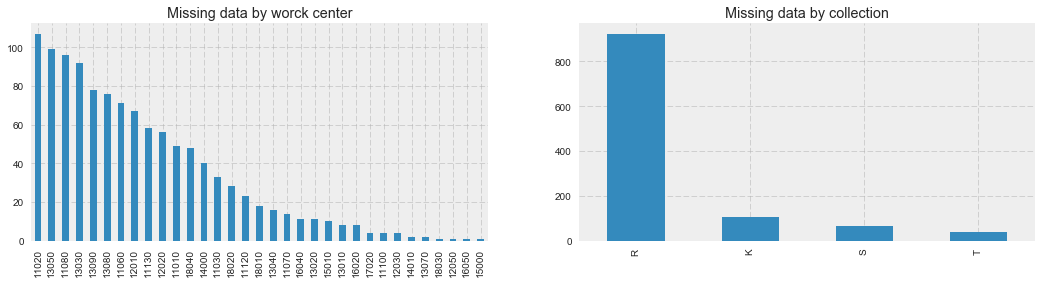

In [57]:
import matplotlib.gridspec as gridspec
import math

def create_plots(fields, columns = 2, width = 18, hight = 4):
    """
    Input:
        fields  = [(field_name, displa title), (...)]
    Output:
        grid of plots
    """
    rows = math.ceil(len(fields)/columns)  
    fig, axes = plt.subplots(rows, columns, figsize=(width, hight))
    
    for idx, field in enumerate(fields, start=0):
        data_nans[field[0]].value_counts().plot(kind='bar', ax = axes[idx]);
        axes[idx].set_title(field[1])
        
    return fig, axes        
        
fields = [('WC', 'Missing data by worck center'),
         ('Collection', 'Missing data by collection')]

create_plots(fields);